In [1]:
                                                                                                                                                                                                                                        # -*- coding: utf-8 -*-
"""
Created on Sun Jul  8 00:11:05 2018

@author: somya
"""

# numpy and pandas for data manipulation
import pandas as pd
import numpy as np

# model used for feature importances
import lightgbm as lgb

# utility for early stopping with a validation set
from sklearn.model_selection import train_test_split

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# memory management
import gc

# utilities
from itertools import chain

class FeatureSelector():
    """
    Class for performing feature selection for machine learning or data preprocessing.
    
    Implements five different methods to identify features for removal 
    
        1. Find columns with a missing percentage greater than a specified threshold
        2. Find columns with a single unique value
        3. Find collinear variables with a correlation greater than a specified correlation coefficient
        4. Find features with 0.0 feature importance from a gradient boosting machine (gbm)
        5. Find low importance features that do not contribute to a specified cumulative feature importance from the gbm
        
    Parameters
    --------
        data : dataframe
            A dataset with observations in the rows and features in the columns
        labels : array or series, default = None
            Array of labels for training the machine learning model to find feature importances. These can be either binary labels
            (if task is 'classification') or continuous targets (if task is 'regression').
            If no labels are provided, then the feature importance based methods are not available.
        
    Attributes
    --------
    
    ops : dict
        Dictionary of operations run and features identified for removal
        
    missing_stats : dataframe
        The fraction of missing values for all features
    
    record_missing : dataframe
        The fraction of missing values for features with missing fraction above threshold
        
    unique_stats : dataframe
        Number of unique values for all features
    
    record_single_unique : dataframe
        Records the features that have a single unique value
        
    corr_matrix : dataframe
        All correlations between all features in the data
    
    record_collinear : dataframe
        Records the pairs of collinear variables with a correlation coefficient above the threshold
        
    feature_importances : dataframe
        All feature importances from the gradient boosting machine
    
    record_zero_importance : dataframe
        Records the zero importance features in the data according to the gbm
    
    record_low_importance : dataframe
        Records the lowest importance features not needed to reach the threshold of cumulative importance according to the gbm
    
    
    Notes
    --------
    
        - All 5 operations can be run with the `identify_all` method.
        - If using feature importances, one-hot encoding is used for categorical variables which creates new columns
    
    """
    
    def __init__(self, data, labels=None):
        
        # Dataset and optional training labels
        self.data = data
        self.labels = labels

        if labels is None:
            print('No labels provided. Feature importance based methods are not available.')
        
        self.base_features = list(data.columns)
        self.one_hot_features = None
        
        # Dataframes recording information about features to remove
        self.record_missing = None
        self.record_single_unique = None
        self.record_collinear = None
        self.record_zero_importance = None
        self.record_low_importance = None
        
        self.missing_stats = None
        self.unique_stats = None
        self.corr_matrix = None
        self.feature_importances = None
        
        # Dictionary to hold removal operations
        self.ops = {}
        
        self.one_hot_correlated = False
        
    def identify_missing(self, missing_threshold):
        """Find the features with a fraction of missing values above `missing_threshold`"""
        
        self.missing_threshold = missing_threshold

        # Calculate the fraction of missing in each column 
        missing_series = self.data.isnull().sum() / self.data.shape[0]
        self.missing_stats = pd.DataFrame(missing_series).rename(columns = {'index': 'feature', 0: 'missing_fraction'})

        # Sort with highest number of missing values on top
        self.missing_stats = self.missing_stats.sort_values('missing_fraction', ascending = False)

        # Find the columns with a missing percentage above the threshold
        record_missing = pd.DataFrame(missing_series[missing_series > missing_threshold]).reset_index().rename(columns = 
                                                                                                               {'index': 'feature', 
                                                                                                                0: 'missing_fraction'})

        to_drop = list(record_missing['feature'])

        self.record_missing = record_missing
        self.ops['missing'] = to_drop
        
        print('%d features with greater than %0.2f missing values.\n' % (len(self.ops['missing']), self.missing_threshold))
        
    def identify_single_unique(self):
        """Finds features with only a single unique value. NaNs do not count as a unique value. """

        # Calculate the unique counts in each column
        unique_counts = self.data.nunique()
        self.unique_stats = pd.DataFrame(unique_counts).rename(columns = {'index': 'feature', 0: 'nunique'})
        self.unique_stats = self.unique_stats.sort_values('nunique', ascending = True)
        
        # Find the columns with only one unique count
        record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 
                                                                                                                0: 'nunique'})

        to_drop = list(record_single_unique['feature'])
    
        self.record_single_unique = record_single_unique
        self.ops['single_unique'] = to_drop
        
        print('%d features with a single unique value.\n' % len(self.ops['single_unique']))
    
    def identify_collinear(self, correlation_threshold, one_hot=False):
        """
        Finds collinear features based on the correlation coefficient between features. 
        For each pair of features with a correlation coefficient greather than `correlation_threshold`,
        only one of the pair is identified for removal. 
        Using code adapted from: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
        
        Parameters
        --------
        correlation_threshold : float between 0 and 1
            Value of the Pearson correlation cofficient for identifying correlation features
        one_hot : boolean, default = False
            Whether to one-hot encode the features before calculating the correlation coefficients
        """
        
        self.correlation_threshold = correlation_threshold
        self.one_hot_correlated = one_hot
        
         # Calculate the correlations between every column
        if one_hot:
            
            # One hot encoding
            features = pd.get_dummies(self.data)
            self.one_hot_features = [column for column in features.columns if column not in self.base_features]

            # Add one hot encoded data to original data
            self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)
            
            corr_matrix = pd.get_dummies(features).corr()

        else:
            corr_matrix = self.data.corr()
        
        self.corr_matrix = corr_matrix
    
        # Extract the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
        
        # Select the features with correlations above the threshold
        # Need to use the absolute value
        to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

        # Dataframe to hold correlated pairs
        record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

        # Iterate through the columns to drop to record pairs of correlated features
        for column in to_drop:

            # Find the correlated features
            corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

            # Find the correlated values
            corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
            drop_features = [column for _ in range(len(corr_features))]    

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': corr_features,
                                             'corr_value': corr_values})

            # Add to dataframe
            record_collinear = record_collinear.append(temp_df, ignore_index = True)

        self.record_collinear = record_collinear
        self.ops['collinear'] = to_drop
        
        print('%d features with a correlation magnitude greater than %0.2f.\n' % (len(self.ops['collinear']), self.correlation_threshold))

    def identify_zero_importance(self, task, eval_metric=None, 
                                 n_iterations=10, early_stopping = True):
        """
        
        Identify the features with zero importance according to a gradient boosting machine.
        The gbm can be trained with early stopping using a validation set to prevent overfitting. 
        The feature importances are averaged over `n_iterations` to reduce variance. 
        
        Uses the LightGBM implementation (http://lightgbm.readthedocs.io/en/latest/index.html)
        Parameters 
        --------
        eval_metric : string
            Evaluation metric to use for the gradient boosting machine for early stopping. Must be
            provided if `early_stopping` is True
        task : string
            The machine learning task, either 'classification' or 'regression'
        n_iterations : int, default = 10
            Number of iterations to train the gradient boosting machine
            
        early_stopping : boolean, default = True
            Whether or not to use early stopping with a validation set when training
        
        
        Notes
        --------
        
        - Features are one-hot encoded to handle the categorical variables before training.
        - The gbm is not optimized for any particular task and might need some hyperparameter tuning
        - Feature importances, including zero importance features, can change across runs
        """

        if early_stopping and eval_metric is None:
            raise ValueError("""eval metric must be provided with early stopping. Examples include "auc" for classification or
                             "l2" for regression.""")
            
        if self.labels is None:
            raise ValueError("No training labels provided.")
        
        # One hot encoding
        features = pd.get_dummies(self.data)
        self.one_hot_features = [column for column in features.columns if column not in self.base_features]

        # Add one hot encoded data to original data
        self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)

        # Extract feature names
        feature_names = list(features.columns)

        # Convert to np array
        features = np.array(features)
        labels = np.array(self.labels).reshape((-1, ))

        # Empty array for feature importances
        feature_importance_values = np.zeros(len(feature_names))
        
        print('Training Gradient Boosting Model\n')
        
        # Iterate through each fold
        for _ in range(n_iterations):

            if task == 'classification':
                model = lgb.LGBMClassifier(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            elif task == 'regression':
                model = lgb.LGBMRegressor(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            else:
                raise ValueError('Task must be either "classification" or "regression"')
                
            # If training using early stopping need a validation set
            if early_stopping:
                
                train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels, test_size = 0.15)

                # Train the model with early stopping
                model.fit(train_features, train_labels, eval_metric = eval_metric,
                          eval_set = [(valid_features, valid_labels)],
                          early_stopping_rounds = 100, verbose = -1)
                
                # Clean up memory
                gc.enable()
                del train_features, train_labels, valid_features, valid_labels
                gc.collect()
                
            else:
                model.fit(features, labels)

            # Record the feature importances
            feature_importance_values += model.feature_importances_ / n_iterations

        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

        # Sort features according to importance
        feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

        # Normalize the feature importances to add up to one
        feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
        feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

        # Extract the features with zero importance
        record_zero_importance = feature_importances[feature_importances['importance'] == 0.0]
        
        to_drop = list(record_zero_importance['feature'])

        self.feature_importances = feature_importances
        self.record_zero_importance = record_zero_importance
        self.ops['zero_importance'] = to_drop
        
        print('\n%d features with zero importance after one-hot encoding.\n' % len(self.ops['zero_importance']))
    
    def identify_low_importance(self, cumulative_importance):
        """
        Finds the lowest importance features not needed to account for `cumulative_importance` fraction
        of the total feature importance from the gradient boosting machine. As an example, if cumulative
        importance is set to 0.95, this will retain only the most important features needed to 
        reach 95% of the total feature importance. The identified features are those not needed.
        Parameters
        --------
        cumulative_importance : float between 0 and 1
            The fraction of cumulative importance to account for 
        """

        self.cumulative_importance = cumulative_importance
        
        # The feature importances need to be calculated before running
        if self.feature_importances is None:
            raise NotImplementedError("""Feature importances have not yet been determined. 
                                         Call the `identify_zero_importance` method first.""")
            
        # Make sure most important features are on top
        self.feature_importances = self.feature_importances.sort_values('cumulative_importance')

        # Identify the features not needed to reach the cumulative_importance
        record_low_importance = self.feature_importances[self.feature_importances['cumulative_importance'] > cumulative_importance]

        to_drop = list(record_low_importance['feature'])

        self.record_low_importance = record_low_importance
        self.ops['low_importance'] = to_drop
    
        print('%d features required for cumulative importance of %0.2f after one hot encoding.' % (len(self.feature_importances) -
                                                                            len(self.record_low_importance), self.cumulative_importance))
        print('%d features do not contribute to cumulative importance of %0.2f.\n' % (len(self.ops['low_importance']),
                                                                                               self.cumulative_importance))
        
    def identify_all(self, selection_params):
        """
        Use all five of the methods to identify features to remove.
        
        Parameters
        --------
            
        selection_params : dict
           Parameters to use in the five feature selection methhods.
           Params must contain the keys ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']
        
        """
        
        # Check for all required parameters
        for param in ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']:
            if param not in selection_params.keys():
                raise ValueError('%s is a required parameter for this method.' % param)
        
        # Implement each of the five methods
        self.identify_missing(selection_params['missing_threshold'])
        self.identify_single_unique()
        self.identify_collinear(selection_params['correlation_threshold'])
        self.identify_zero_importance(task = selection_params['task'], eval_metric = selection_params['eval_metric'])
        self.identify_low_importance(selection_params['cumulative_importance'])
        
        # Find the number of features identified to drop
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        self.n_identified = len(self.all_identified)
        
        print('%d total features out of %d identified for removal after one-hot encoding.\n' % (self.n_identified, 
                                                                                                  self.data_all.shape[1]))
        
    def check_removal(self, keep_one_hot=True):
        
        """Check the identified features before removal. Returns a list of the unique features identified."""
        
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        print('Total of %d features identified for removal' % len(self.all_identified))
        
        if not keep_one_hot:
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                one_hot_to_remove = [x for x in self.one_hot_features if x not in self.all_identified]
                print('%d additional one-hot features can be removed' % len(one_hot_to_remove))
        
        return list(self.all_identified)
        
    
    def remove(self, methods, keep_one_hot = True):
        """
        Remove the features from the data according to the specified methods.
        
        Parameters
        --------
            methods : 'all' or list of methods
                If methods == 'all', any methods that have identified features will be used
                Otherwise, only the specified methods will be used.
                Can be one of ['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance']
            keep_one_hot : boolean, default = True
                Whether or not to keep one-hot encoded features
                
        Return
        --------
            data : dataframe
                Dataframe with identified features removed
                
        
        Notes 
        --------
            - If feature importances are used, the one-hot encoded columns will be added to the data (and then may be removed)
            - Check the features that will be removed before transforming data!
        
        """
        
        
        features_to_drop = []
      
        if methods == 'all':
            
            # Need to use one-hot encoded data as well
            data = self.data_all
                                          
            print('{} methods have been run\n'.format(list(self.ops.keys())))
            
            # Find the unique features to drop
            features_to_drop = set(list(chain(*list(self.ops.values()))))
            
        else:
            # Need to use one-hot encoded data as well
            if 'zero_importance' in methods or 'low_importance' in methods or self.one_hot_correlated:
                data = self.data_all
                
            else:
                data = self.data
                
            # Iterate through the specified methods
            for method in methods:
                
                # Check to make sure the method has been run
                if method not in self.ops.keys():
                    raise NotImplementedError('%s method has not been run' % method)
                    
                # Append the features identified for removal
                else:
                    features_to_drop.append(self.ops[method])
        
            # Find the unique features to drop
            features_to_drop = set(list(chain(*features_to_drop)))
            
        features_to_drop = list(features_to_drop)
            
        if not keep_one_hot:
            
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                             
                features_to_drop = list(set(features_to_drop) | set(self.one_hot_features))
       
        # Remove the features and return the data
        data = data.drop(columns = features_to_drop)
        self.removed_features = features_to_drop
        
        if not keep_one_hot:
        	print('Removed %d features including one-hot features.' % len(features_to_drop))
        else:
        	print('Removed %d features.' % len(features_to_drop))
        
        return data
    
    def plot_missing(self):
        """Histogram of missing fraction in each feature"""
        if self.record_missing is None:
            raise NotImplementedError("Missing values have not been calculated. Run `identify_missing`")
        
        self.reset_plot()
        
        # Histogram of missing values
        plt.style.use('seaborn-white')
        plt.figure(figsize = (7, 5))
        plt.hist(self.missing_stats['missing_fraction'], bins = np.linspace(0, 1, 11), edgecolor = 'k', color = 'red', linewidth = 1.5)
        plt.xticks(np.linspace(0, 1, 11));
        plt.xlabel('Missing Fraction', size = 14); plt.ylabel('Count of Features', size = 14); 
        plt.title("Fraction of Missing Values Histogram", size = 16);
        
    
    def plot_unique(self):
        """Histogram of number of unique values in each feature"""
        if self.record_single_unique is None:
            raise NotImplementedError('Unique values have not been calculated. Run `identify_single_unique`')
        
        self.reset_plot()

        # Histogram of number of unique values
        self.unique_stats.plot.hist(edgecolor = 'k', figsize = (7, 5))
        plt.ylabel('Frequency', size = 14); plt.xlabel('Unique Values', size = 14); 
        plt.title('Number of Unique Values Histogram', size = 16);
        
    
    def plot_collinear(self, plot_all = False):
        """
        Heatmap of the correlation values. If plot_all = True plots all the correlations otherwise
        plots only those features that have a correlation above the threshold
        
        Notes
        --------
            - Not all of the plotted correlations are above the threshold because this plots
            all the variables that have been idenfitied as having even one correlation above the threshold
            - The features on the x-axis are those that will be removed. The features on the y-axis
            are the correlated features with those on the x-axis
        
        Code adapted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        """
        
        if self.record_collinear is None:
            raise NotImplementedError('Collinear features have not been idenfitied. Run `identify_collinear`.')
        
        if plot_all:
        	corr_matrix_plot = self.corr_matrix
        	title = 'All Correlations'
        
        else:
	        # Identify the correlations that were above the threshold
	        # columns (x-axis) are features to drop and rows (y_axis) are correlated pairs
	        corr_matrix_plot = self.corr_matrix.loc[list(set(self.record_collinear['corr_feature'])), 
	                                                list(set(self.record_collinear['drop_feature']))]

	        title = "Correlations Above Threshold"

       
        f, ax = plt.subplots(figsize=(10, 8))
        
        # Diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        # Draw the heatmap with a color bar
        sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
                    linewidths=.25, cbar_kws={"shrink": 0.6})

        # Set the ylabels 
        ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
        ax.set_yticklabels(list(corr_matrix_plot.index), size = int(160 / corr_matrix_plot.shape[0]));

        # Set the xlabels 
        ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
        ax.set_xticklabels(list(corr_matrix_plot.columns), size = int(160 / corr_matrix_plot.shape[1]));
        plt.title(title, size = 14)
        
    def plot_feature_importances(self, plot_n = 15, threshold = None):
        """
        Plots `plot_n` most important features and the cumulative importance of features.
        If `threshold` is provided, prints the number of features needed to reach `threshold` cumulative importance.
        Parameters
        --------
        
        plot_n : int, default = 15
            Number of most important features to plot. Defaults to 15 or the maximum number of features whichever is smaller
        
        threshold : float, between 0 and 1 default = None
            Threshold for printing information about cumulative importances
        """
        
        if self.record_zero_importance is None:
            raise NotImplementedError('Feature importances have not been determined. Run `idenfity_zero_importance`')
            
        # Need to adjust number of features if greater than the features in the data
        if plot_n > self.feature_importances.shape[0]:
            plot_n = self.feature_importances.shape[0] - 1

        self.reset_plot()
        
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        # There might be a more efficient method to accomplish this
        ax.barh(list(reversed(list(self.feature_importances.index[:plot_n]))), 
                self.feature_importances['normalized_importance'][:plot_n], 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(self.feature_importances.index[:plot_n]))))
        ax.set_yticklabels(self.feature_importances['feature'][:plot_n], size = 12)

        # Plot labeling
        plt.xlabel('Normalized Importance', size = 16); plt.title('Feature Importances', size = 18)
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (6, 4))
        plt.plot(list(range(1, len(self.feature_importances) + 1)), self.feature_importances['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features', size = 14); plt.ylabel('Cumulative Importance', size = 14); 
        plt.title('Cumulative Feature Importance', size = 16);

        if threshold:

            # Index of minimum number of features needed for cumulative importance threshold
            # np.where returns the index so need to add 1 to have correct number
            importance_index = np.min(np.where(self.feature_importances['cumulative_importance'] > threshold))
            plt.vlines(x = importance_index + 1, ymin = 0, ymax = 1, linestyles='--', colors = 'blue')
            plt.show();

            print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    def reset_plot(self):
        plt.rcParams = plt.rcParamsDefault

In [1]:
import pandas as pd
import numpy as np

#from feature_selector_lightgbm import FeatureSelector

In [2]:
train = pd.read_csv('C:\\Users\\somya\\Documents\\CS 6220 Data Mining Techniques\\Project\\New folder\\Data without Missing Value\\application_train.csv')
train_features = train
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
train_features["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

### RANDOM UNDER SAMPLING

In [4]:
# Class count
count_class_0, count_class_1 = train_features.TARGET.value_counts()

# Divide by class
df_class_0 = train_features[train_features['TARGET'] == 0]
df_class_1 = train_features[train_features['TARGET'] == 1]

Random under-sampling:
1    24825
0    24825
Name: TARGET, dtype: int64


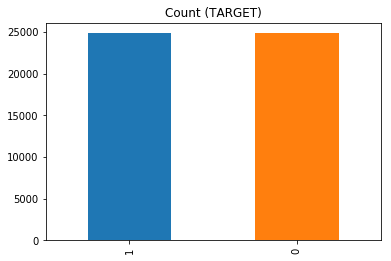

In [5]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.TARGET.value_counts())

df_test_under.TARGET.value_counts().plot(kind='bar', title='Count (TARGET)');

In [6]:
train_labels = df_test_under['TARGET']

In [7]:
train = df_test_under.drop(columns = ['TARGET'])

In [8]:
fs = FeatureSelector(data = train, labels = train_labels)

In [9]:
fs.identify_missing(missing_threshold=0.6)

23 features with greater than 0.60 missing values.



In [10]:
missing_features = fs.ops['missing']
missing_features[:10]

['OWN_CAR_AGE',
 'BASEMENTAREA_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'BASEMENTAREA_MODE',
 'YEARS_BUILD_MODE']

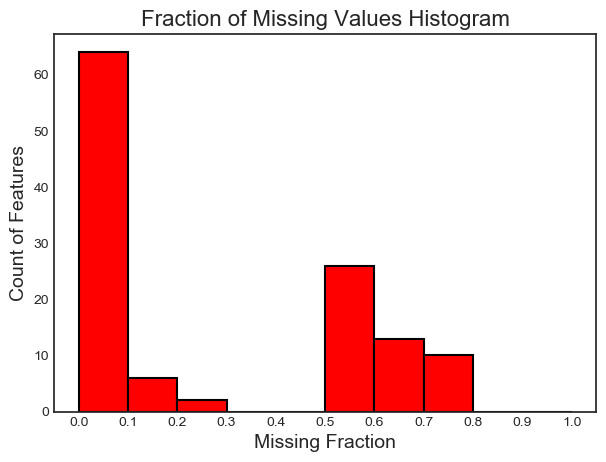

In [11]:
fs.plot_missing()

In [12]:

fs.missing_stats.head(10)

,missing_fraction
COMMONAREA_AVG,0.717805
COMMONAREA_MODE,0.717805
COMMONAREA_MEDI,0.717805
NONLIVINGAPARTMENTS_AVG,0.713656
NONLIVINGAPARTMENTS_MODE,0.713656
NONLIVINGAPARTMENTS_MEDI,0.713656
FONDKAPREMONT_MODE,0.704834
LIVINGAPARTMENTS_MEDI,0.704532
LIVINGAPARTMENTS_AVG,0.704532
LIVINGAPARTMENTS_MODE,0.704532


In [13]:
fs.identify_single_unique()

2 features with a single unique value.



In [14]:
single_unique = fs.ops['single_unique']
single_unique

['FLAG_MOBIL', 'FLAG_DOCUMENT_12']

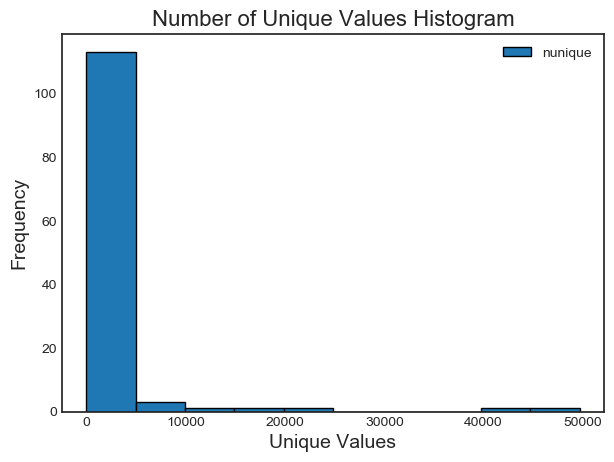

In [15]:
fs.plot_unique()

In [16]:
fs.unique_stats.sample(5)

,nunique
FLAG_DOCUMENT_11,2
NAME_TYPE_SUITE,7
FLAG_DOCUMENT_3,2
NAME_FAMILY_STATUS,5
AMT_ANNUITY,8565


In [17]:
fs.identify_collinear(correlation_threshold=0.975)


29 features with a correlation magnitude greater than 0.97.



In [18]:
correlated_features = fs.ops['collinear']
correlated_features[:5]

['AMT_GOODS_PRICE',
 'FLAG_EMP_PHONE',
 'APARTMENTS_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE']

In [19]:
fs.record_collinear.head()

,corr_feature,corr_value,drop_feature
0,AMT_CREDIT,0.985377,AMT_GOODS_PRICE
1,DAYS_EMPLOYED,-0.999653,FLAG_EMP_PHONE
2,APARTMENTS_AVG,0.975851,APARTMENTS_MODE
3,YEARS_BEGINEXPLUATATION_AVG,0.976755,YEARS_BEGINEXPLUATATION_MODE
4,YEARS_BUILD_AVG,0.989143,YEARS_BUILD_MODE


In [20]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[157]	valid_0's auc: 0.751596
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[253]	valid_0's auc: 0.758985
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[432]	valid_0's auc: 0.765189
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[215]	valid_0's auc: 0.750849
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[226]	valid_0's auc: 0.759068
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[254]	valid_0's auc: 0.756754
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[174]	valid_0's auc: 0.756336
Training until validation scores don't improve for 100 rounds.
Early s

In [21]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 121 original features
There are 138 one-hot features


In [22]:
train_features.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
fs.data_all.head()

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
206701,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
155843,1,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
14127,0,1,1,0,0,0,1,0,1,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
102884,1,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
117408,1,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [24]:

zero_importance_features= fs.ops['zero_importance']
zero_importance_features

['ORGANIZATION_TYPE_Mobile',
 'HOUSETYPE_MODE_specific housing',
 'ORGANIZATION_TYPE_XNA',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_12',
 'NAME_HOUSING_TYPE_Co-op apartment',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_20',
 'NAME_EDUCATION_TYPE_Academic degree',
 'FLAG_MOBIL',
 'NAME_INCOME_TYPE_Unemployed',
 'WALLSMATERIAL_MODE_Monolithic',
 'NAME_INCOME_TYPE_Student',
 'FLAG_DOCUMENT_21',
 'NAME_INCOME_TYPE_Maternity leave',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'OCCUPATION_TYPE_HR staff',
 'ORGANIZATION_TYPE_Transport: type 2',
 'ORGANIZATION_TYPE_Industry: type 8',
 'ORGANIZATION_TYPE_Advertising',
 'ORGANIZATION_TYPE_Industry: type 6',
 'ORGANIZATION_TYPE_Industry: type 13',
 'ORGANIZATION_TYPE_Religion',
 'ORGANIZATION_TYPE_Industry: type 10',
 'ORGANIZATION_TYPE_Culture',
 'FLAG_OWN_CAR_N',
 'ORGANIZATION_TYPE_Cleaning',
 'ORGANIZATION_TYPE_Telecom',
 'ORGANIZATION_TYPE_Transport: type 1',
 'ORGANIZATION_TYPE_Trade: type 1',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_4',
 '

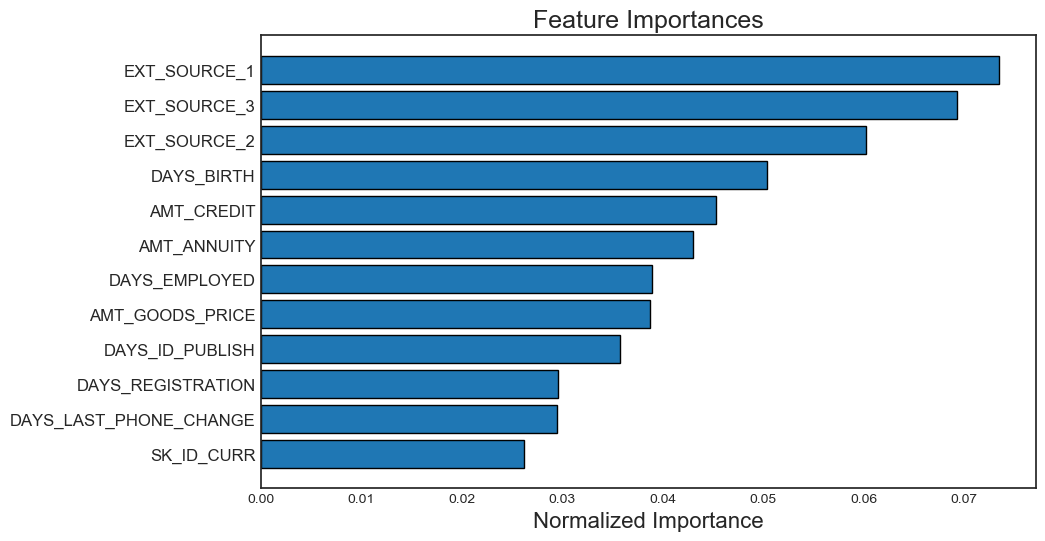

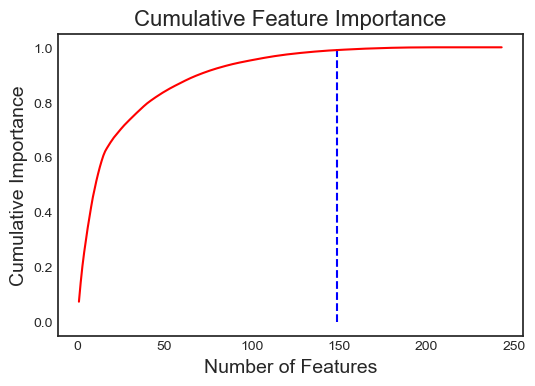

149 features required for 0.99 of cumulative importance


In [25]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [26]:
fs.feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,EXT_SOURCE_1,511.2,0.073417,0.073417
1,EXT_SOURCE_3,482.5,0.069295,0.142711
2,EXT_SOURCE_2,419.5,0.060247,0.202958
3,DAYS_BIRTH,350.4,0.050323,0.253282
4,AMT_CREDIT,315.1,0.045253,0.298535
5,AMT_ANNUITY,299.2,0.042970,0.341505
6,DAYS_EMPLOYED,270.8,0.038891,0.380396
7,AMT_GOODS_PRICE,269.4,0.038690,0.419087
8,DAYS_ID_PUBLISH,248.6,0.035703,0.454790
9,DAYS_REGISTRATION,206.3,0.029628,0.484418


In [27]:
fs.identify_low_importance(cumulative_importance = 0.99)

148 features required for cumulative importance of 0.99 after one hot encoding.
95 features do not contribute to cumulative importance of 0.99.



In [28]:
low_importance_features = fs.ops['low_importance']
low_importance_features[:5]

['FONDKAPREMONT_MODE_reg oper account',
 'ORGANIZATION_TYPE_Legal Services',
 'WALLSMATERIAL_MODE_Others',
 'NAME_HOUSING_TYPE_With parents',
 'ORGANIZATION_TYPE_Trade: type 7']

In [29]:

fs=  FeatureSelector(data = train, labels = train_labels)

fs.identify_all(selection_params = {'missing_threshold': 0.6, 'correlation_threshold': 0.98, 
                                    'task': 'classification', 'eval_metric': 'auc', 
                                     'cumulative_importance': 0.99})

23 features with greater than 0.60 missing values.

2 features with a single unique value.

22 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[272]	valid_0's auc: 0.74949
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[330]	valid_0's auc: 0.764747
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[373]	valid_0's auc: 0.75695
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[250]	valid_0's auc: 0.754785
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[435]	valid_0's auc: 0.757638
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[359]	valid_0's auc: 0.75149
Training until validation scores don't improve f

In [30]:
train_no_missing_zero = fs.remove(methods = ['missing', 'zero_importance'], keep_one_hot = False)

Removed 171 features including one-hot features.


In [31]:
train_no_missing_zero

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
206701,339582,Cash loans,F,Y,Y,0,225000.0,1223010.0,48631.5,1125000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
155843,280646,Cash loans,F,N,Y,1,135000.0,647046.0,25200.0,463500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
14127,116470,Revolving loans,F,Y,Y,2,157500.0,202500.0,10125.0,202500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
102884,219429,Cash loans,M,N,Y,0,81000.0,103500.0,10732.5,103500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
117408,236149,Cash loans,F,N,Y,2,112500.0,781920.0,34573.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
124626,244530,Cash loans,F,N,Y,0,171000.0,521280.0,28278.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,7.0
185725,315307,Cash loans,F,N,N,1,67500.0,582471.0,27283.5,409500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
50063,157953,Cash loans,M,Y,N,0,270000.0,675000.0,32472.0,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
283472,428319,Revolving loans,M,Y,Y,0,81000.0,180000.0,9000.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
230106,366523,Cash loans,M,Y,Y,0,135000.0,577147.5,31437.0,459000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
train_removed_all = fs.remove(methods = 'all', keep_one_hot=False)

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 192 features including one-hot features.


In [33]:
train_removed_all

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_8,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
206701,339582,Cash loans,F,Y,Y,0,225000.0,1223010.0,48631.5,Unaccompanied,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
155843,280646,Cash loans,F,N,Y,1,135000.0,647046.0,25200.0,Unaccompanied,...,0,0,0,0,0,0,0.0,0.0,0.0,2.0
14127,116470,Revolving loans,F,Y,Y,2,157500.0,202500.0,10125.0,Unaccompanied,...,0,0,0,0,0,0,0.0,0.0,0.0,1.0
102884,219429,Cash loans,M,N,Y,0,81000.0,103500.0,10732.5,"Spouse, partner",...,0,0,0,0,0,0,0.0,0.0,0.0,3.0
117408,236149,Cash loans,F,N,Y,2,112500.0,781920.0,34573.5,Unaccompanied,...,0,0,0,0,0,0,0.0,0.0,0.0,2.0
124626,244530,Cash loans,F,N,Y,0,171000.0,521280.0,28278.0,Unaccompanied,...,0,0,0,0,0,0,0.0,0.0,0.0,7.0
185725,315307,Cash loans,F,N,N,1,67500.0,582471.0,27283.5,Unaccompanied,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
50063,157953,Cash loans,M,Y,N,0,270000.0,675000.0,32472.0,Unaccompanied,...,0,0,0,0,0,0,0.0,0.0,0.0,3.0
283472,428319,Revolving loans,M,Y,Y,0,81000.0,180000.0,9000.0,Unaccompanied,...,0,0,0,0,0,0,0.0,0.0,0.0,2.0
230106,366523,Cash loans,M,Y,Y,0,135000.0,577147.5,31437.0,Unaccompanied,...,1,0,0,0,0,0,NaN,NaN,NaN,NaN


In [34]:
train_removed_all.shape

(49650, 67)

In [35]:
train_removed_all.to_csv('app_train_removed_all_76.csv')

**Encoding on the train file**

In [36]:
train=train_removed_all

In [37]:
#Label Encoder

# Create a label encoder object
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            #app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)


3 columns were label encoded.


In [38]:
# One-Hot encoding of categorical variables

train = pd.get_dummies(train)
#app_test = pd.get_dummies(app_test)

print('Training Features shape: ', train.shape)

Training Features shape:  (49650, 183)


**Load test set**

In [39]:
test = pd.read_csv('C:\\Users\\somya\\Documents\\CS 6220 Data Mining Techniques\\Project\\New folder\\Data without Missing Value\\application_train.csv')

In [40]:
#train = pd.read_csv("C:/SHARYU/NEU/Unsupervised2/Project/application_train.csv/application_train.csv",  header=0, sep=',', quotechar='"')
test_features = test
#train_labels = train['TARGET']
test.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


**Encoding test set**

In [41]:
#Label Encoder

# Create a label encoder object
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in test:
    if test[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(test[col].unique())) <= 2:
            # Train on the training data
            le.fit(test[col])
            # Transform both training and testing data
            test[col] = le.transform(test[col])
            #app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)


3 columns were label encoded.


In [42]:
# One-Hot encoding of categorical variables

test = pd.get_dummies(test)


print('Test Features shape: ', test.shape)

Test Features shape:  (307511, 243)


**Align train test**

In [43]:

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['TARGET'] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (49650, 184)
Testing Features shape:  (307511, 183)


**Impute missing values in train and test set**

In [44]:
# Impute missing values

from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in train:
    train1 = train.drop(columns = ['TARGET'])
else:
    train1 = train.copy()
    
# Feature names
features = list(train1.columns)

# Copy of the testing data
test1 = test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'most_frequent')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train1)

# Transform both training and testing data
train1 = imputer.transform(train1)
test1 = imputer.transform(test1)

# Repeat with the scaler
scaler.fit(train1)
train1 = scaler.transform(train1)
test1 = scaler.transform(test1)

print('Training data shape: ', train1.shape)
print('Testing data shape: ', test1.shape)

Training data shape:  (49650, 183)
Testing data shape:  (307511, 183)


In [45]:
from sklearn.model_selection import train_test_split

# create training and testing vars

X_train, X_test, y_train, y_test = train_test_split(train1, train_labels, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(39720, 183) (39720,)
(9930, 183) (9930,)


**Logistic Regression**

In [ ]:


# Logistic Regrssion 


from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

# RIDGE 
## create a list of alpha to test out 
alphas = 10**np.linspace(10,-2,100)*0.5


##standardize the variables
ridge = Ridge(normalize=True)
coefs = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    np.shape(coefs)

# Plotting the L2 regularization
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')


In [46]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(X_train, y_train)
predictionRes = logistic.predict(X_test)
logistic_score = logistic.score(X_test, y_test)
logistic_score

0.6774420946626385

ROC score for Logistic Regression:  0.6774420946626385


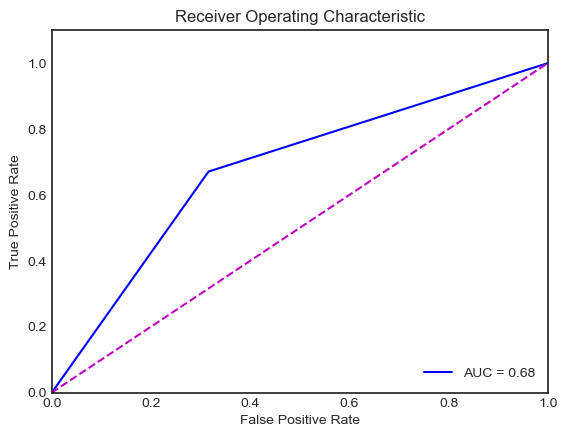

In [47]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
import matplotlib.pyplot as plt
print("ROC score for Logistic Regression: ", roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'blue', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'m--')
plt.xlim([0,1])
plt.ylim([0,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [48]:
# Precision score and Recall score using sklearn

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

average_precision = average_precision_score(y_test.tolist(), predictionRes)
precision = precision_score(y_test.tolist(), predictionRes)
recall = recall_score(y_test.tolist(), predictionRes)
print('Precision score : {0:0.2f}'.format(precision))
print('Recall score : {0:0.2f}'.format(recall))

# Print classification report using sklearn
print (classification_report(y_test.tolist(), predictionRes, digits=4))


Precision score : 0.68
Recall score : 0.67
             precision    recall  f1-score   support

          0     0.6751    0.6840    0.6795      4965
          1     0.6798    0.6709    0.6753      4965

avg / total     0.6775    0.6774    0.6774      9930



Text(0.5,1,'2-class Precision-Recall curve: AP=0.62')

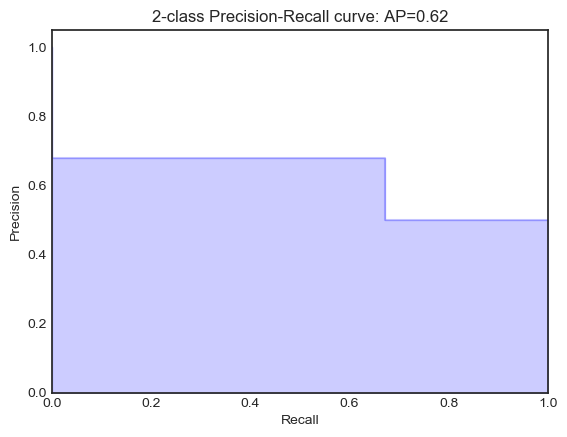

In [49]:
# Plot the precision-recall curve

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test.tolist(), predictionRes)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

**K-Nearest Neighbors**

In [50]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
predictionRes = model.predict(X_test)
print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

Accuracy score: 0.5599194360523666
ROC score :  0.5599194360523665


In [51]:
# Precision score and Recall score using sklearn

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

average_precision = average_precision_score(y_test.tolist(), predictionRes)
precision = precision_score(y_test.tolist(), predictionRes)
recall = recall_score(y_test.tolist(), predictionRes)
print('Precision score : {0:0.2f}'.format(precision))
print('Recall score : {0:0.2f}'.format(recall))

# Print classification report using sklearn
print (classification_report(y_test.tolist(), predictionRes, digits=4))


Precision score : 0.56
Recall score : 0.58
             precision    recall  f1-score   support

          0     0.5625    0.5392    0.5506      4965
          1     0.5575    0.5807    0.5689      4965

avg / total     0.5600    0.5599    0.5597      9930



Text(0.5,1,'2-class Precision-Recall curve: AP=0.53')

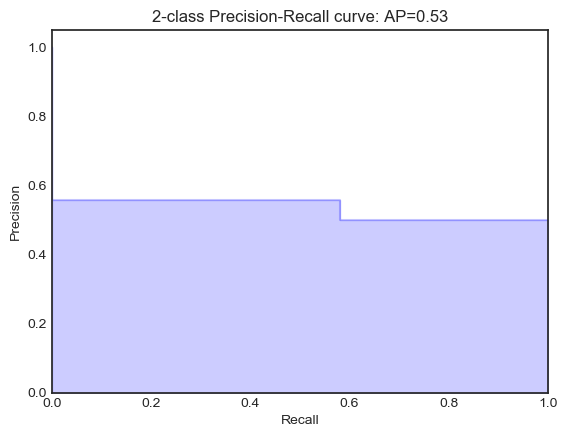

In [52]:
# Plot the precision-recall curve

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test.tolist(), predictionRes)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

**Gaussian Naive Bayes**

In [53]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
predictionRes = model.predict(X_test)
print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

Accuracy score: 0.5745216515609265
ROC score :  0.5745216515609266


In [54]:
# Precision score and Recall score using sklearn

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

average_precision = average_precision_score(y_test.tolist(), predictionRes)
precision = precision_score(y_test.tolist(), predictionRes)
recall = recall_score(y_test.tolist(), predictionRes)
print('Precision score : {0:0.2f}'.format(precision))
print('Recall score : {0:0.2f}'.format(recall))

# Print classification report using sklearn
print (classification_report(y_test.tolist(), predictionRes, digits=4))


Precision score : 0.55
Recall score : 0.85
             precision    recall  f1-score   support

          0     0.6637    0.3021    0.4152      4965
          1     0.5482    0.8469    0.6656      4965

avg / total     0.6060    0.5745    0.5404      9930



**Adaboost**

In [55]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(random_state=1)
model.fit(X_train, y_train)
predictionRes = model.predict(X_test)
model.score(X_test,y_test)


0.6828801611278953

ROC score for Adaboost:  0.6828801611278953


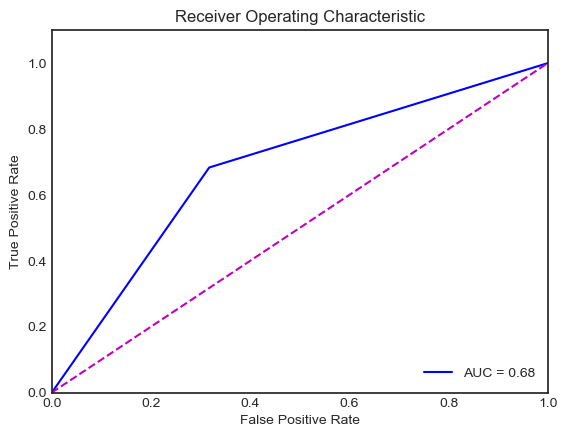

In [56]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score for Adaboost: ", roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'blue', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'m--')
plt.xlim([0,1])
plt.ylim([0,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [57]:
# Precision score and Recall score using sklearn

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

average_precision = average_precision_score(y_test.tolist(), predictionRes)
precision = precision_score(y_test.tolist(), predictionRes)
recall = recall_score(y_test.tolist(), predictionRes)
print('Precision score : {0:0.2f}'.format(precision))
print('Recall score : {0:0.2f}'.format(recall))

# Print classification report using sklearn
print (classification_report(y_test.tolist(), predictionRes, digits=4))


Precision score : 0.68
Recall score : 0.68
             precision    recall  f1-score   support

          0     0.6830    0.6826    0.6828      4965
          1     0.6828    0.6832    0.6830      4965

avg / total     0.6829    0.6829    0.6829      9930



**Random Forest**

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
model= RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
model.fit(X_train, y_train)
predictionRes = model.predict(X_test)
print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Accuracy score: 0.6772406847935549
ROC score :  0.6772406847935549


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [59]:
# Precision score and Recall score using sklearn

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

average_precision = average_precision_score(y_test.tolist(), predictionRes)
precision = precision_score(y_test.tolist(), predictionRes)
recall = recall_score(y_test.tolist(), predictionRes)
print('Precision score : {0:0.2f}'.format(precision))
print('Recall score : {0:0.2f}'.format(recall))

# Print classification report using sklearn
print (classification_report(y_test.tolist(), predictionRes, digits=4))


Precision score : 0.69
Recall score : 0.65
             precision    recall  f1-score   support

          0     0.6687    0.7025    0.6852      4965
          1     0.6867    0.6520    0.6689      4965

avg / total     0.6777    0.6772    0.6770      9930



**Extra Trees Classification**

In [60]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import model_selection
seed = 7
num_trees = 100
max_features = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.6534743202416917


In [61]:
# Precision score and Recall score using sklearn

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

average_precision = average_precision_score(y_test.tolist(), predictionRes)
precision = precision_score(y_test.tolist(), predictionRes)
recall = recall_score(y_test.tolist(), predictionRes)
print('Precision score : {0:0.2f}'.format(precision))
print('Recall score : {0:0.2f}'.format(recall))

# Print classification report using sklearn
print (classification_report(y_test.tolist(), predictionRes, digits=4))


Precision score : 0.69
Recall score : 0.65
             precision    recall  f1-score   support

          0     0.6687    0.7025    0.6852      4965
          1     0.6867    0.6520    0.6689      4965

avg / total     0.6777    0.6772    0.6770      9930



**Support Vector Machine Classifier**

In [62]:
from sklearn import svm
model = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)  
predictionRes = model.predict(X_test)
print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

Accuracy score: 0.6768378650553877
ROC score :  0.6768378650553877


In [63]:
# Precision score and Recall score using sklearn

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

average_precision = average_precision_score(y_test.tolist(), predictionRes)
precision = precision_score(y_test.tolist(), predictionRes)
recall = recall_score(y_test.tolist(), predictionRes)
print('Precision score : {0:0.2f}'.format(precision))
print('Recall score : {0:0.2f}'.format(recall))

# Print classification report using sklearn
print (classification_report(y_test.tolist(), predictionRes, digits=4))


Precision score : 0.68
Recall score : 0.67
             precision    recall  f1-score   support

          0     0.6742    0.6844    0.6793      4965
          1     0.6796    0.6693    0.6744      4965

avg / total     0.6769    0.6768    0.6768      9930



**Bagging Classifier**

In [64]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
model.fit(X_train, y_train)
predictionRes = model.predict(X_test)
print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

Accuracy score: 0.6450151057401813
ROC score :  0.6450151057401812


In [65]:
# Precision score and Recall score using sklearn

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

average_precision = average_precision_score(y_test.tolist(), predictionRes)
precision = precision_score(y_test.tolist(), predictionRes)
recall = recall_score(y_test.tolist(), predictionRes)
print('Precision score : {0:0.2f}'.format(precision))
print('Recall score : {0:0.2f}'.format(recall))

# Print classification report using sklearn
print (classification_report(y_test.tolist(), predictionRes, digits=4))


Precision score : 0.67
Recall score : 0.57
             precision    recall  f1-score   support

          0     0.6261    0.7198    0.6697      4965
          1     0.6705    0.5702    0.6163      4965

avg / total     0.6483    0.6450    0.6430      9930



**Gradient Boosting (GBM)**

In [66]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
model.fit(X_train, y_train)
predictionRes = model.predict(X_test)
print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

Accuracy score: 0.6648539778449144
ROC score :  0.6648539778449144


In [67]:
# Precision score and Recall score using sklearn

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

average_precision = average_precision_score(y_test.tolist(), predictionRes)
precision = precision_score(y_test.tolist(), predictionRes)
recall = recall_score(y_test.tolist(), predictionRes)
print('Precision score : {0:0.2f}'.format(precision))
print('Recall score : {0:0.2f}'.format(recall))

# Print classification report using sklearn
print (classification_report(y_test.tolist(), predictionRes, digits=4))


Precision score : 0.66
Recall score : 0.69
             precision    recall  f1-score   support

          0     0.6733    0.6405    0.6565      4965
          1     0.6572    0.6892    0.6728      4965

avg / total     0.6652    0.6649    0.6647      9930



**LightGBM**

In [68]:
import lightgbm as lgb
lgb_train = lgb.Dataset(data=X_train, label=y_train)
lgb_eval = lgb.Dataset(data=X_test, label=y_test)


In [69]:
params = {'task': 'train', 'boosting_type': 'goss', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 35, 'num_iteration': 10000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.01, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.753973
[400]	valid_0's auc: 0.760324
[600]	valid_0's auc: 0.762655
[800]	valid_0's auc: 0.763226
[1000]	valid_0's auc: 0.763918
Early stopping, best iteration is:
[1002]	valid_0's auc: 0.76396


In [70]:
predictionRes = model.predict(X_test)

In [71]:
#print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

ROC score :  0.7639600060443243


ROC score for LightGBM 0.7639600060443243


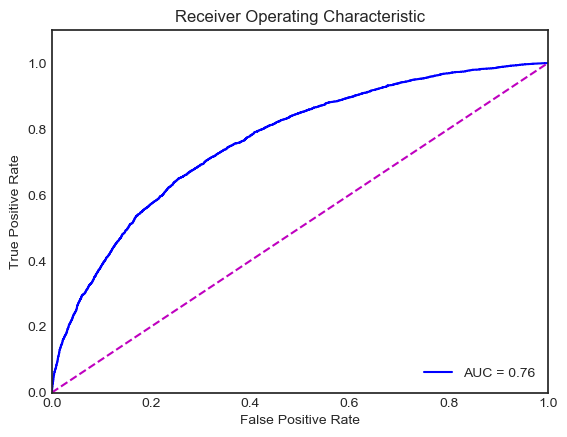

In [72]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score for LightGBM", roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'blue', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'m--')
plt.xlim([0,1])
plt.ylim([0,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [73]:
params = {'task': 'train', 'boosting_type': 'dart', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 35, 'num_iteration': 10000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.01, 'reg_lambda':.01, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.74651
[400]	valid_0's auc: 0.749061
[600]	valid_0's auc: 0.752002
[800]	valid_0's auc: 0.754044
[1000]	valid_0's auc: 0.75568
[1200]	valid_0's auc: 0.756582
[1400]	valid_0's auc: 0.757518
[1600]	valid_0's auc: 0.75816
[1800]	valid_0's auc: 0.758833
[2000]	valid_0's auc: 0.759171
[2200]	valid_0's auc: 0.75936
[2400]	valid_0's auc: 0.75976
[2600]	valid_0's auc: 0.76001
Early stopping, best iteration is:
[2639]	valid_0's auc: 0.760057


In [74]:
predictionRes = model.predict(X_test)

In [75]:
#print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

ROC score :  0.7600645809690999


In [76]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 35, 'num_iteration': 10000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.01, 'reg_lambda':.01, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)

Training until validation scores don't improve for 150 rounds.


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	valid_0's auc: 0.751922
[400]	valid_0's auc: 0.758908
[600]	valid_0's auc: 0.762262
[800]	valid_0's auc: 0.763763
[1000]	valid_0's auc: 0.764271
[1200]	valid_0's auc: 0.764455
Early stopping, best iteration is:
[1116]	valid_0's auc: 0.764527


In [77]:
predictionRes = model.predict(X_test)

In [78]:
#print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

ROC score :  0.764526590463557


In [79]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc',
          'learning_rate': 0.01, 'num_leaves': 35, 'num_iteration': 10000, 'feature_fraction': 0.9,'bagging_fraction': 0.9,
          'bagging_freq': 5, 'verbose': 0,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.01, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)

predictionRes = model.predict(X_test)

#print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

Training until validation scores don't improve for 150 rounds.


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	valid_0's auc: 0.751335
[400]	valid_0's auc: 0.75907
[600]	valid_0's auc: 0.762397
[800]	valid_0's auc: 0.763982
[1000]	valid_0's auc: 0.76485
Early stopping, best iteration is:
[1005]	valid_0's auc: 0.764935
ROC score :  0.7649349677348691


In [80]:
params = {'task': 'train', 'boosting_type': 'dart', 'objective': 'binary', 'metric': 'auc',
          'learning_rate': 0.01, 'num_leaves': 35, 'num_iteration': 10000, 'feature_fraction': 0.9,'bagging_fraction': 0.9,
          'bagging_freq': 2, 'verbose': 1,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.01, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=200, verbose_eval=200)

predictionRes = model.predict(X_test)

#print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

Training until validation scores don't improve for 200 rounds.


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	valid_0's auc: 0.744085
[400]	valid_0's auc: 0.74838
[600]	valid_0's auc: 0.752236
[800]	valid_0's auc: 0.754241
[1000]	valid_0's auc: 0.756089
[1200]	valid_0's auc: 0.757248
[1400]	valid_0's auc: 0.758427
[1600]	valid_0's auc: 0.759178
[1800]	valid_0's auc: 0.760043
[2000]	valid_0's auc: 0.760537
[2200]	valid_0's auc: 0.761453
[2400]	valid_0's auc: 0.762125
[2600]	valid_0's auc: 0.762622
[2800]	valid_0's auc: 0.762701
[3000]	valid_0's auc: 0.763096
[3200]	valid_0's auc: 0.763161
[3400]	valid_0's auc: 0.763407
[3600]	valid_0's auc: 0.76362
[3800]	valid_0's auc: 0.763854
[4000]	valid_0's auc: 0.763904
[4200]	valid_0's auc: 0.763972
Early stopping, best iteration is:
[4166]	valid_0's auc: 0.764041
ROC score :  0.7640573642891986


In [81]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc',
          'learning_rate': 0.01, 'num_leaves': 35, 'num_iteration': 10000, 'feature_fraction': 0.9,'bagging_fraction': 0.9,
          'bagging_freq': 5, 'verbose': 1,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':5, 'reg_alpha':.01, 'reg_lambda':.1, 
          'min_split_gain':.001, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)

predictionRes = model.predict(X_test)

#print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

Training until validation scores don't improve for 150 rounds.


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	valid_0's auc: 0.747706
[400]	valid_0's auc: 0.75649
[600]	valid_0's auc: 0.760463
[800]	valid_0's auc: 0.76252
[1000]	valid_0's auc: 0.763772
[1200]	valid_0's auc: 0.764131
[1400]	valid_0's auc: 0.764404
[1600]	valid_0's auc: 0.764553
[1800]	valid_0's auc: 0.764696
[2000]	valid_0's auc: 0.764774
Early stopping, best iteration is:
[1925]	valid_0's auc: 0.764895
ROC score :  0.7648952536841475


In [82]:
# Precision score and Recall score using sklearn

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

average_precision = average_precision_score(y_test.tolist(), predictionRes.round())
precision = precision_score(y_test.tolist(), predictionRes.round())
recall = recall_score(y_test.tolist(), predictionRes.round())
print('Precision score : {0:0.2f}'.format(precision))
print('Recall score : {0:0.2f}'.format(recall))

# Print classification report using sklearn
print (classification_report(y_test.tolist(), predictionRes.round(), digits=4))


Precision score : 0.70
Recall score : 0.69
             precision    recall  f1-score   support

          0     0.6927    0.7011    0.6969      4965
          1     0.6975    0.6890    0.6932      4965

avg / total     0.6951    0.6951    0.6951      9930



Text(0.5,1,'2-class Precision-Recall curve: AP=0.64')

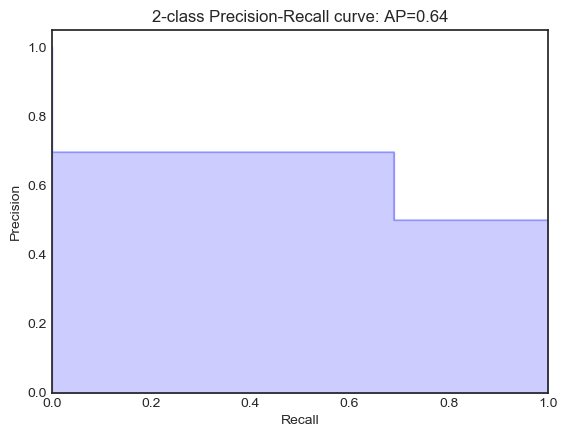

In [83]:
# Plot the precision-recall curve

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test.tolist(), predictionRes.round())

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

#### XGBoost

In [84]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [85]:
ratio = (train_labels == 0).sum()/ (train_labels == 1).sum()
ratio

1.0

In [86]:
clf = XGBClassifier(n_estimators=1000, objective='binary:logistic', gamma=0.1, subsample=0.5)
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=10)

[0]	validation_0-auc:0.690683
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.696911
[2]	validation_0-auc:0.704403
[3]	validation_0-auc:0.707409
[4]	validation_0-auc:0.711782
[5]	validation_0-auc:0.714153
[6]	validation_0-auc:0.715772
[7]	validation_0-auc:0.716177
[8]	validation_0-auc:0.717168
[9]	validation_0-auc:0.720438
[10]	validation_0-auc:0.723833
[11]	validation_0-auc:0.725497
[12]	validation_0-auc:0.727205
[13]	validation_0-auc:0.727631
[14]	validation_0-auc:0.7295
[15]	validation_0-auc:0.731114
[16]	validation_0-auc:0.733037
[17]	validation_0-auc:0.735121
[18]	validation_0-auc:0.736054
[19]	validation_0-auc:0.737813
[20]	validation_0-auc:0.738373
[21]	validation_0-auc:0.739258
[22]	validation_0-auc:0.739908
[23]	validation_0-auc:0.74067
[24]	validation_0-auc:0.740863
[25]	validation_0-auc:0.741046
[26]	validation_0-auc:0.741942
[27]	validation_0-auc:0.742199
[28]	validation_0-auc:0.742931
[29]	validation_0-auc:0.743957
[30]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

In [87]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

predictionRes = clf.predict(X_test)
print("Accuracy score:" ,clf.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

Accuracy score: 0.6945619335347432
ROC score :  0.6945619335347432


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0.5,1,'2-class Precision-Recall curve: AP=0.64')

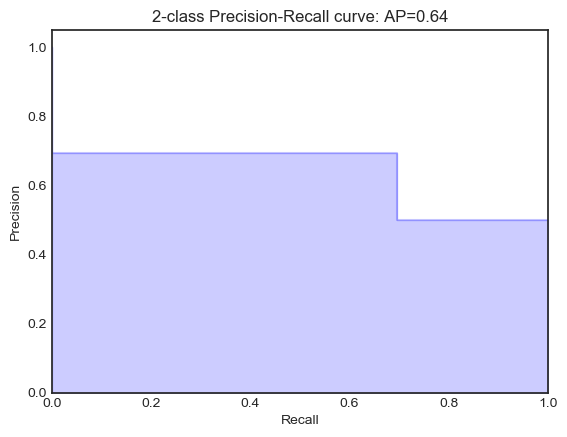

In [88]:
# Plot the precision-recall curve

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(y_test.tolist(), predictionRes.round())

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

## Hyperparameter tuning using grid search (for logistic regression)

Previous Score - 66.67

In [89]:
from sklearn.model_selection import GridSearchCV

In [90]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [91]:
# Create grid search using 5-fold cross validation
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

In [92]:
# Fit grid search
best_model = clf.fit(X_train, y_train)

In [93]:
clf.score(X_test, y_test)

0.6777442094662638

In [94]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1291.5496650148827


In [95]:
from sklearn import svm, grid_search, datasets
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [96]:
clf.score(X_test, y_test)

0.6775427995971802

### Polynomial features 
> We tried polynomial features technique in an attempt to increase the accuracy score. 

In [97]:
train = pd.read_csv('C:\\Users\\somya\\Documents\\CS 6220 Data Mining Techniques\\Project\\New folder\\Data without Missing Value\\application_train.csv')
train_features = train
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
test = pd.read_csv('C:\\Users\\somya\\Documents\\CS 6220 Data Mining Techniques\\Project\\New folder\\Data without Missing Value\\application_test.csv')


In [99]:
# Make a new dataframe for polynomial features
poly_features = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [100]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [101]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [102]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


In [113]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = train['SK_ID_CURR']
app_train_poly = train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')


# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = test['SK_ID_CURR']
app_test_poly = test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)
app_train_poly['TARGET'] = poly_target
# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 145)
Testing data with polynomial features shape:   (48744, 144)


In [114]:
app_train_poly.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,TARGET
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0.009637,-654.152107,0.005108,-346.733022,2.353667e+07,0.002707,-183.785678,1.247560e+07,-8.468590e+11,1
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0.207254,-6491.237078,0.178286,-5583.975307,1.748916e+08,0.153368,-4803.518937,1.504475e+08,-4.712058e+12,0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0.225464,-5885.942404,0.295894,-7724.580288,2.016572e+08,0.388325,-10137.567875,2.646504e+08,-6.908939e+12,0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0.226462,-8040.528832,0.186365,-6616.894625,2.349331e+08,0.153368,-5445.325225,1.933364e+08,-6.864416e+12,0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0.055754,-2076.117157,0.092471,-3443.335521,1.282190e+08,0.153368,-5710.929881,2.126570e+08,-7.918677e+12,0


In [115]:
app_train_poly['TARGET']

0         1
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        1
27        0
28        0
29        0
         ..
307481    1
307482    0
307483    0
307484    0
307485    0
307486    0
307487    0
307488    0
307489    1
307490    0
307491    0
307492    0
307493    0
307494    0
307495    0
307496    0
307497    0
307498    0
307499    0
307500    0
307501    0
307502    0
307503    0
307504    0
307505    0
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

Random under-sampling:
1    24825
0    24825
Name: TARGET, dtype: int64


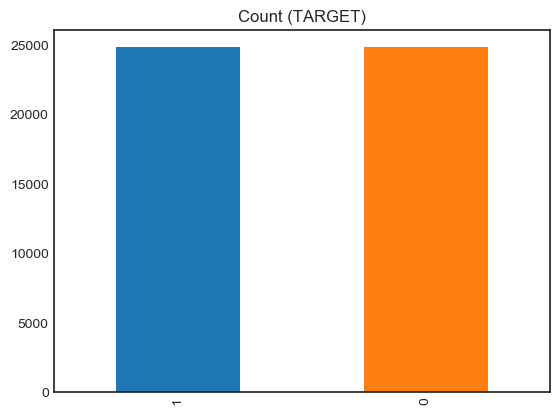

In [123]:
# Class count
count_class_0, count_class_1 = app_train_poly.TARGET.value_counts()

# Divide by class
df_class_0 = app_train_poly[app_train_poly['TARGET'] == 0]
df_class_1 = app_train_poly[app_train_poly['TARGET'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
train = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(train.TARGET.value_counts())

train.TARGET.value_counts().plot(kind='bar', title='Count (TARGET)');

In [124]:
poly_target = app_train_poly['TARGET']

In [125]:
fs_poly = FeatureSelector(data = train, labels = poly_target)

In [ ]:

fs=  FeatureSelector(data = app_train_poly, labels = poly_target)

fs.identify_all(selection_params = {'missing_threshold': 0.6, 'correlation_threshold': 0.98, 
                                    'task': 'classification', 'eval_metric': 'auc', 
                                     'cumulative_importance': 0.99})

16 features with greater than 0.60 missing values.

1 features with a single unique value.



16 features with greater than 0.60 missing values.



MemoryError: 

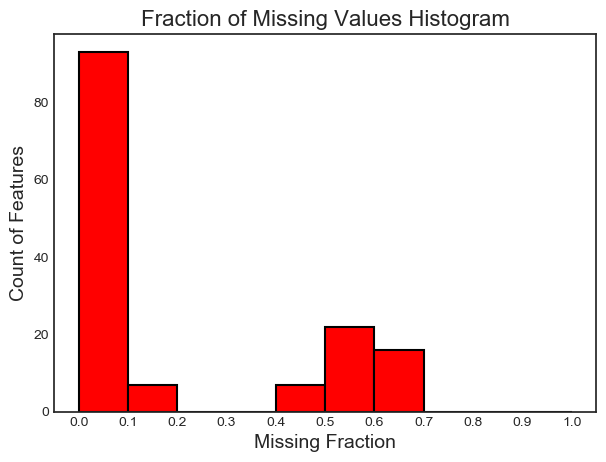

In [121]:
fs = FeatureSelector(data = app_train_poly, labels =poly_target)

fs.identify_missing(missing_threshold=0.6)

missing_features = fs.ops['missing']
missing_features[:10]

fs.plot_missing()


fs.missing_stats.head(10)

fs.identify_single_unique()

single_unique = fs.ops['single_unique']
single_unique

fs.plot_unique()

fs.unique_stats.sample(5)

fs.identify_collinear(correlation_threshold=0.975)


correlated_features = fs.ops['collinear']
correlated_features[:5]

fs.record_collinear.head()

fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

#train_features.head()

fs.data_all.head()


zero_importance_features= fs.ops['zero_importance']
zero_importance_features

fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

fs.feature_importances.head(10)

fs.identify_low_importance(cumulative_importance = 0.99)

low_importance_features = fs.ops['low_importance']
low_importance_features[:5]


#fs=  FeatureSelector(data = train, labels = train_labels)

fs.identify_all(selection_params = {'missing_threshold': 0.6, 'correlation_threshold': 0.98, 
                                    'task': 'classification', 'eval_metric': 'auc', 
                                     'cumulative_importance': 0.99})

train_no_missing_zero = fs.remove(methods = ['missing', 'zero_importance'], keep_one_hot = False)

train_no_missing_zero



In [122]:
train_removed_all = fs.remove(methods = 'all', keep_one_hot=False)

AttributeError: 'FeatureSelector' object has no attribute 'data_all'

In [ ]:
train = train_removed_all

In [ ]:
#Label Encoder

# Create a label encoder object
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            #app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)


# One-Hot encoding of categorical variables

train = pd.get_dummies(train)
#app_test = pd.get_dummies(app_test)

print('Training Features shape: ', train.shape)

In [ ]:
#Label Encoder

# Create a label encoder object
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_test_poly:
    if app_test_poly[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_test_poly[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_test_poly[col])
            # Transform both training and testing data
            test[col] = le.transform(app_test_poly[col])
            #app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)


# One-Hot encoding of categorical variables

test = pd.get_dummies(test)


print('Test Features shape: ', test.shape)

In [ ]:

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
#train['TARGET'] = poly_features

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

In [ ]:
# Impute missing values

from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in train:
    train1 = train.drop(columns = ['TARGET'])
else:
    train1 = train.copy()
    
# Feature names
features = list(train1.columns)

# Copy of the testing data
test1 = test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'most_frequent')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train1)

# Transform both training and testing data
train1 = imputer.transform(train1)
test1 = imputer.transform(test1)

# Repeat with the scaler
scaler.fit(train1)
train1 = scaler.transform(train1)
test1 = scaler.transform(test1)

print('Training data shape: ', train1.shape)
print('Testing data shape: ', test1.shape)

In [ ]:
from sklearn.model_selection import train_test_split

# create training and testing vars

X_train, X_test, y_train, y_test = train_test_split(train1, poly_target, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

In [ ]:
import lightgbm as lgb
lgb_train = lgb.Dataset(data=X_train, label=y_train)
lgb_eval = lgb.Dataset(data=X_test, label=y_test)

In [ ]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc',
          'learning_rate': 0.01, 'num_leaves': 35, 'num_iteration': 10000, 'feature_fraction': 0.9,'bagging_fraction': 0.9,
          'bagging_freq': 5, 'verbose': 0,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.01, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)

predictionRes = model.predict(X_test)

#print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

In [ ]:
params = {'task': 'train', 'boosting_type': 'dart', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 35, 'num_iteration': 10000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.01, 'reg_lambda':.01, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)

predictionRes = model.predict(X_test)

#print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

In [ ]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 35, 'num_iteration': 10000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.01, 'reg_lambda':.01, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)

predictionRes = model.predict(X_test)

#print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

In [ ]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(X_train, y_train)
predictionRes = logistic.predict(X_test)
logistic_score = logistic.score(X_test, y_test)


In [ ]:
logistic_score

ROC score for Logistic Regression:  0.6774420946626385


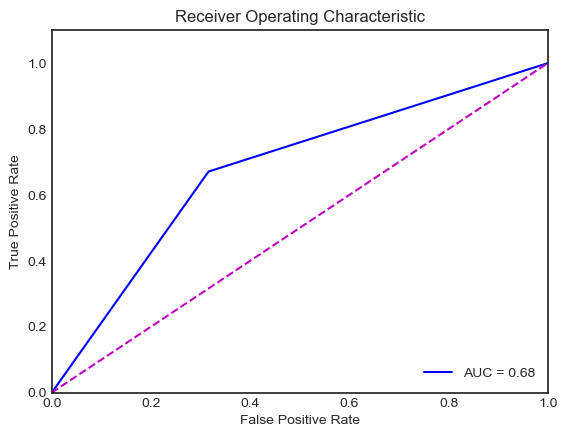

In [111]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
import matplotlib.pyplot as plt
print("ROC score for Logistic Regression: ", roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'blue', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'m--')
plt.xlim([0,1])
plt.ylim([0,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [112]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
predictionRes = model.predict(X_test)
print("Accuracy score:" ,model.score(X_test,y_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.tolist(), predictionRes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("ROC score : ", roc_auc)

# Precision score and Recall score using sklearn

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

average_precision = average_precision_score(y_test.tolist(), predictionRes)
precision = precision_score(y_test.tolist(), predictionRes)
recall = recall_score(y_test.tolist(), predictionRes)
print('Precision score : {0:0.2f}'.format(precision))
print('Recall score : {0:0.2f}'.format(recall))

# Print classification report using sklearn
print (classification_report(y_test.tolist(), predictionRes, digits=4))


Accuracy score: 0.5599194360523666
ROC score :  0.5599194360523665
Precision score : 0.56
Recall score : 0.58
             precision    recall  f1-score   support

          0     0.5625    0.5392    0.5506      4965
          1     0.5575    0.5807    0.5689      4965

avg / total     0.5600    0.5599    0.5597      9930



### Ensemble Learning